# Project_Notes_004

## Bankruptcy in Poland
In this project, a data consisting of 5 arff files is combined to form a dataframe with 43405 rows and 65 columns which will be used to predict bankruptcy, the column Y. the process involves dealing with the appropriate methods: missing values, colinearity columns, ouliers and class inbalance. Finally, a model pipeline that consists of SimpleImputer, StandardScaler and XGBClassifier will be instantiated to complete the prediction task with the production of confusion matrix and class inportance.

In [1]:
# To supress warnings.
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Import reqired libraries.
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from lazypredict.Supervised import LazyClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
                                ConfusionMatrixDisplay,
                                classification_report,
                                confusion_matrix,
                            )
from sklearn.model_selection import (
                                        GridSearchCV, 
                                        train_test_split, 
                                        cross_val_score
                                    )
from sklearn.pipeline import make_pipeline
from sklearn.base import ClassifierMixin
from sklearn.pipeline import Pipeline
from scipy.io import arff
import missingno as msno

In [2]:
# Define data path.
path = 'data/Project_Notes_004_'

In [3]:
# Load the 5 raw .arff files.
N=5
arff_list = [arff.loadarff(path + str(i+1) + 'year.arff') for i in range(N)]

# Convert load_raw into pandas dataframes
data_list = [pd.DataFrame(data_i_year[0]) for data_i_year in arff_list]

# Combine the dataframes into one
df = pd.concat([data for data in data_list], axis=0, ignore_index=True)

In [4]:
# Set the column headers from X1 to X64 and the class label as Y.
cols = ['X' + str(i+1) for i in range(len(df.columns)-1)]
cols.append('Y')
df.columns = cols

In [5]:
# Check column names.
df.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41',
       'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51',
       'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61',
       'X62', 'X63', 'X64', 'Y'],
      dtype='object')

In [6]:
# Convert target values to integer type.
Y_values = {b'0': 0,
            b'1': 1}

df['Y'] = df['Y'].map(Y_values)

In [7]:
# Preview df.
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.20,0.38,0.40,2.05,32.35,0.39,0.25,1.33,1.14,0.50,...,0.12,0.40,0.88,0.00,8.42,5.14,82.66,4.42,7.43,0
1,0.21,0.50,0.47,1.94,14.79,0.00,0.26,1.00,1.70,0.50,...,0.12,0.42,0.85,0.00,4.15,3.27,107.35,3.40,60.99,0
2,0.25,0.70,0.27,1.55,-1.15,0.00,0.31,0.44,1.31,0.30,...,0.24,0.82,0.77,0.69,4.99,3.95,134.27,2.72,5.21,0
3,0.08,0.31,0.46,2.49,51.95,0.15,0.09,1.87,1.06,0.57,...,0.05,0.14,0.95,0.00,4.57,3.61,86.44,4.22,5.55,0
4,0.19,0.61,0.23,1.41,-7.31,0.19,0.19,0.63,1.16,0.39,...,0.13,0.48,0.87,0.12,6.40,4.32,127.21,2.87,7.90,0


In [8]:
# Check df shape.
df.shape

(43405, 65)

In [9]:
# Check df data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      43397 non-null  float64
 1   X2      43397 non-null  float64
 2   X3      43397 non-null  float64
 3   X4      43271 non-null  float64
 4   X5      43316 non-null  float64
 5   X6      43397 non-null  float64
 6   X7      43397 non-null  float64
 7   X8      43311 non-null  float64
 8   X9      43396 non-null  float64
 9   X10     43397 non-null  float64
 10  X11     43361 non-null  float64
 11  X12     43271 non-null  float64
 12  X13     43278 non-null  float64
 13  X14     43397 non-null  float64
 14  X15     43369 non-null  float64
 15  X16     43310 non-null  float64
 16  X17     43311 non-null  float64
 17  X18     43397 non-null  float64
 18  X19     43277 non-null  float64
 19  X20     43278 non-null  float64
 20  X21     37551 non-null  float64
 21  X22     43397 non-null  float64
 22

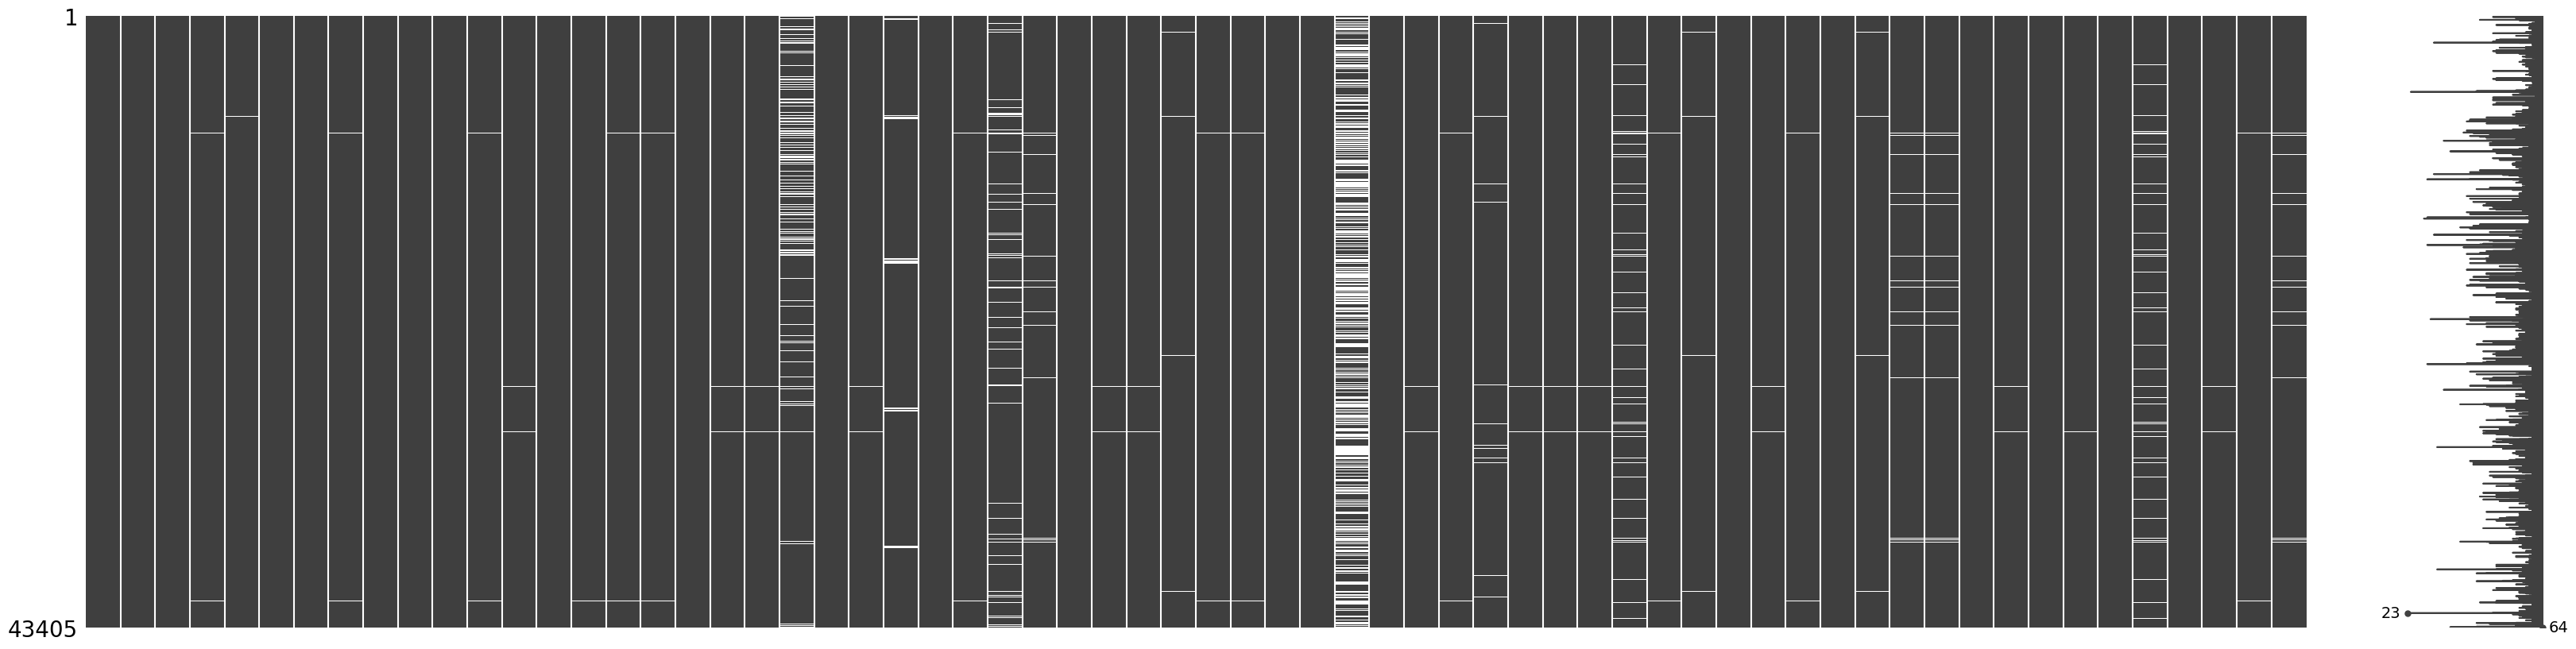

In [10]:
# Generate sparsity matrix for df.
def sparsity_matrix(dataframe):
    missing_df = dataframe.columns[dataframe.isnull().any()].tolist()
    msno.matrix(dataframe[missing_df], figsize=(40,10))

sparsity_matrix(df)

In [11]:
# Check df for missing values.
df.isna().sum()

X1       8
X2       8
X3       8
X4     134
X5      89
      ... 
X61    102
X62    127
X63    134
X64    812
Y        0
Length: 65, dtype: int64

In [12]:
# Function to enumerate missing values.
def missing_values(df):
    print('col_name' + '\t' + 'miss_val' + '\t' + 'per_miss')
    miss_col = []

    for col in df.columns:
        miss_val = df[col].isna().sum()
        per_miss = round(miss_val * 100 / df.shape[0])
        print(col + '\t-' + '\t', str(miss_val) + '\t-' + '\t', per_miss)

        if per_miss > 40:
            miss_col.append(col)

    print('\nColumns with more than 40% missing values\n', miss_col)

In [13]:
# Check df for missing values.
missing_values(df)

col_name	miss_val	per_miss
X1	-	 8	-	 0
X2	-	 8	-	 0
X3	-	 8	-	 0
X4	-	 134	-	 0
X5	-	 89	-	 0
X6	-	 8	-	 0
X7	-	 8	-	 0
X8	-	 94	-	 0
X9	-	 9	-	 0
X10	-	 8	-	 0
X11	-	 44	-	 0
X12	-	 134	-	 0
X13	-	 127	-	 0
X14	-	 8	-	 0
X15	-	 36	-	 0
X16	-	 95	-	 0
X17	-	 94	-	 0
X18	-	 8	-	 0
X19	-	 128	-	 0
X20	-	 127	-	 0
X21	-	 5854	-	 13
X22	-	 8	-	 0
X23	-	 127	-	 0
X24	-	 922	-	 2
X25	-	 8	-	 0
X26	-	 95	-	 0
X27	-	 2764	-	 6
X28	-	 812	-	 2
X29	-	 8	-	 0
X30	-	 127	-	 0
X31	-	 127	-	 0
X32	-	 368	-	 1
X33	-	 134	-	 0
X34	-	 94	-	 0
X35	-	 8	-	 0
X36	-	 8	-	 0
X37	-	 18984	-	 44
X38	-	 8	-	 0
X39	-	 127	-	 0
X40	-	 134	-	 0
X41	-	 754	-	 2
X42	-	 127	-	 0
X43	-	 127	-	 0
X44	-	 127	-	 0
X45	-	 2147	-	 5
X46	-	 135	-	 0
X47	-	 297	-	 1
X48	-	 9	-	 0
X49	-	 127	-	 0
X50	-	 94	-	 0
X51	-	 8	-	 0
X52	-	 301	-	 1
X53	-	 812	-	 2
X54	-	 812	-	 2
X55	-	 1	-	 0
X56	-	 127	-	 0
X57	-	 7	-	 0
X58	-	 84	-	 0
X59	-	 7	-	 0
X60	-	 2152	-	 5
X61	-	 102	-	 0
X62	-	 127	-	 0
X63	-	 134	-	 0
X64	-	 812	-	 2


In [14]:
# Drop colummes with more than 40% missing values and check shape.
df.drop(['X37'], axis=1, inplace=True)
df.shape

(43405, 64)

In [15]:
# Subset numerical features.
df_num = df.select_dtypes("number")

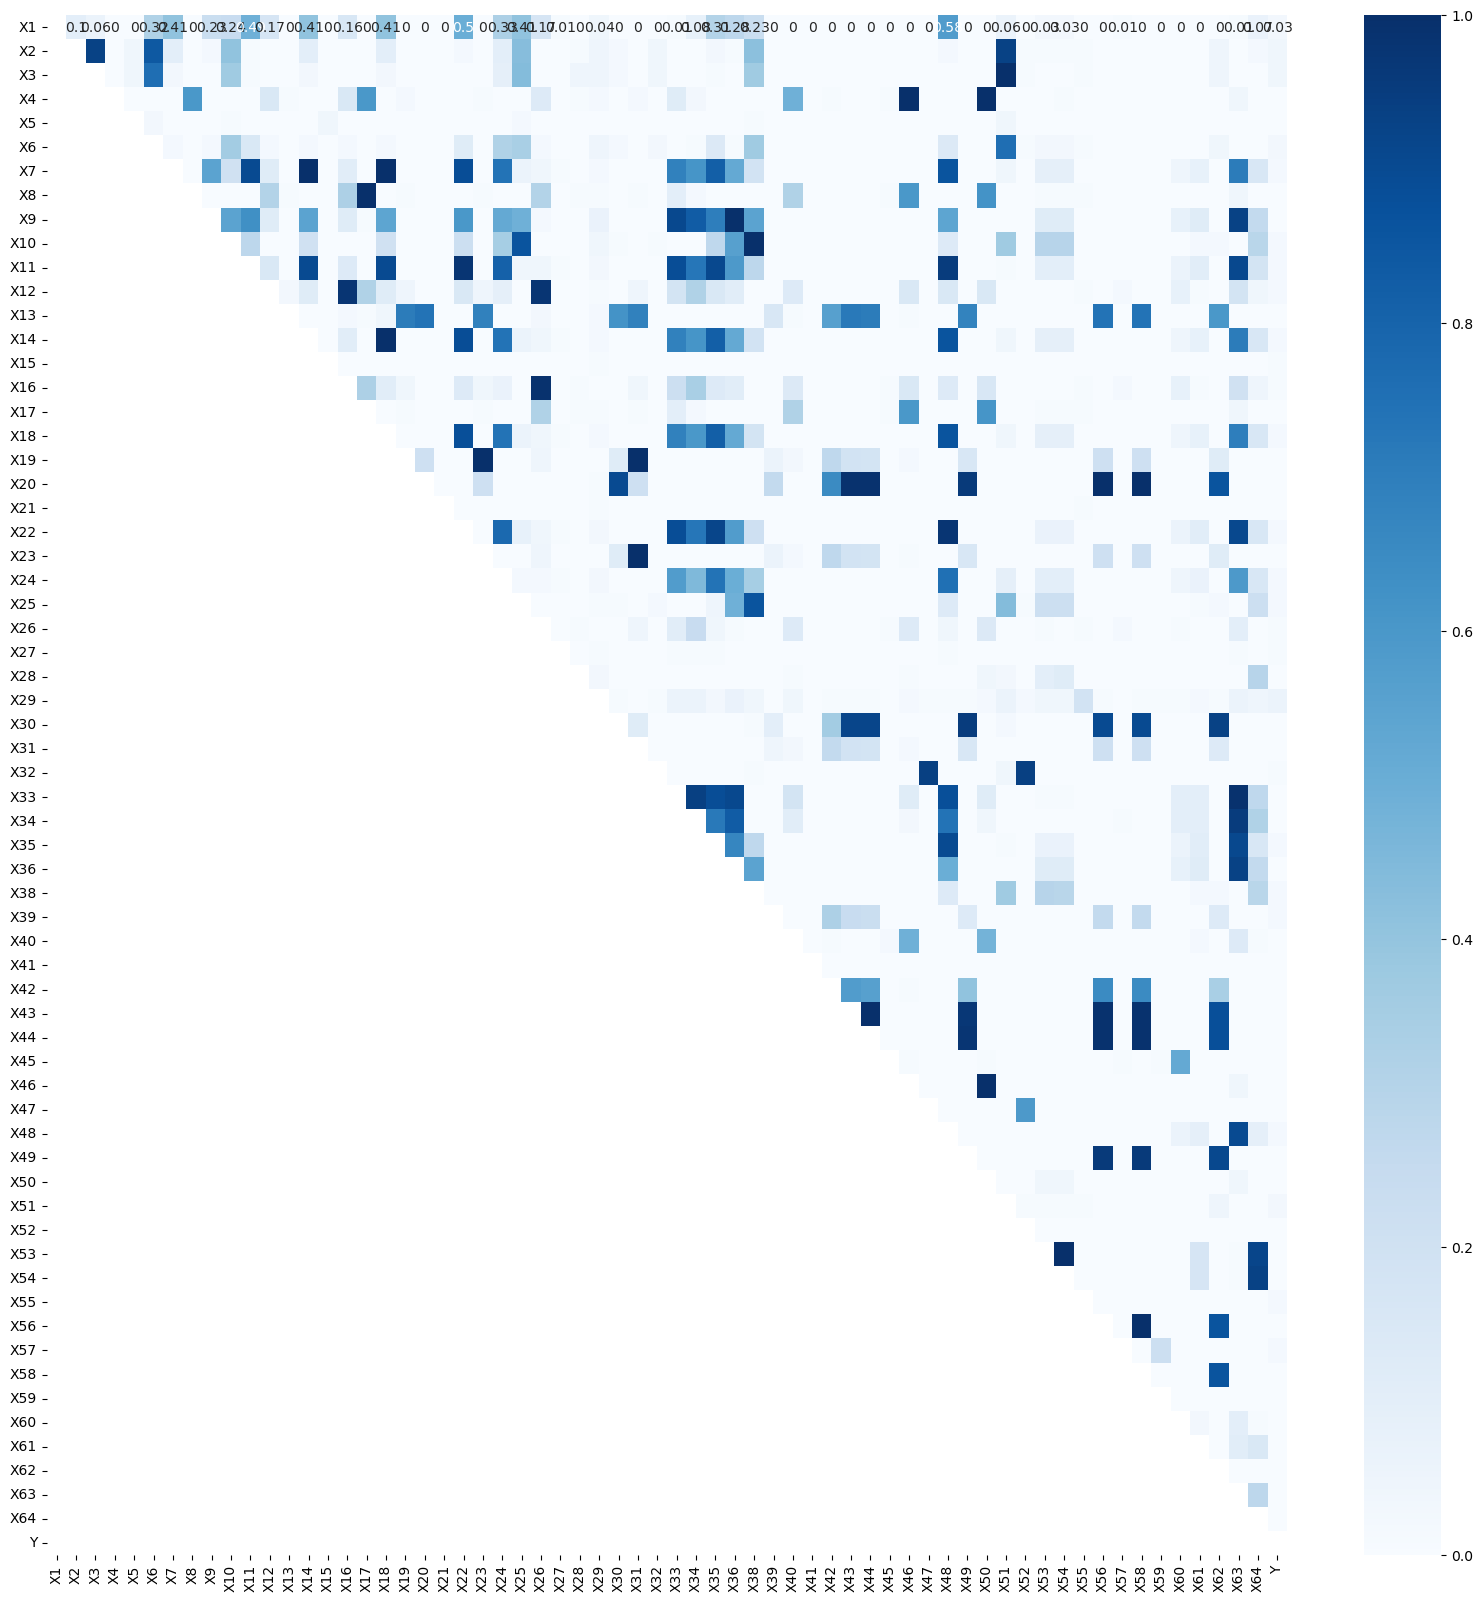

In [16]:
# Create correlation matrix.
corr_matrix = df_num.corr().abs().round(2)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Plot heatmap of correlation
plt.figure(figsize = (20,20))
sns.heatmap(upper, cmap="Blues", annot=True);

In [17]:
# Find features with correlation greater than 0.8.
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
to_drop

['X3',
 'X6',
 'X11',
 'X14',
 'X16',
 'X17',
 'X18',
 'X22',
 'X23',
 'X24',
 'X25',
 'X26',
 'X30',
 'X31',
 'X33',
 'X34',
 'X35',
 'X36',
 'X38',
 'X43',
 'X44',
 'X46',
 'X47',
 'X48',
 'X49',
 'X50',
 'X51',
 'X52',
 'X54',
 'X56',
 'X58',
 'X62',
 'X63',
 'X64']

In [18]:
# Drop the features.
df.drop(to_drop, axis=1, inplace=True)
df.shape

(43405, 30)

In [19]:
# Subset numerical features again.
df_num = df.select_dtypes("number")

In [20]:
# Get df statistics
df_stat = df_num.describe()
df_stat

,X1,X2,X4,X5,X7,X8,X9,X10,X12,X13,...,X41,X42,X45,X53,X55,X57,X59,X60,X61,Y
count,43397.00,43397.00,43271.00,43316.00,43397.00,43311.00,43396.00,43397.00,43271.00,43278.00,...,42651.00,43278.00,41258.00,42593.00,43404.00,43398.00,43398.00,41253.00,43303.00,43405.00
mean,0.04,0.59,6.31,-385.35,0.09,12.64,2.65,0.63,1.13,0.81,...,7.72,-0.14,14.83,23.77,7672.19,-0.01,1.33,448.09,17.03,0.05
std,2.99,5.84,295.43,61243.03,5.71,505.89,62.93,14.67,67.59,86.94,...,1398.84,15.99,2428.24,1213.80,70053.10,13.67,122.10,32345.60,553.05,0.21
min,-463.89,-430.87,-0.40,-11903000.00,-517.48,-141.41,-3.50,-479.91,-6331.80,-1460.60,...,-1234.40,-1395.80,-256230.00,-3828.90,-1805200.00,-1667.30,-327.97,-12.44,-12.66,0.00
25%,0.00,0.27,1.05,-49.08,0.01,0.43,1.02,0.30,0.02,0.02,...,0.03,0.00,0.02,0.69,27.55,0.01,0.00,5.55,4.51,0.00
50%,0.05,0.47,1.57,-1.03,0.06,1.07,1.20,0.51,0.17,0.07,...,0.09,0.04,0.28,1.21,1088.35,0.12,0.01,9.79,6.64,0.00
75%,0.13,0.69,2.79,50.63,0.15,2.62,2.06,0.71,0.59,0.13,...,0.21,0.09,0.96,2.22,4993.32,0.28,0.24,20.18,10.39,0.00
max,94.28,480.96,53433.00,1250100.00,649.23,53432.00,9742.30,1099.50,8259.40,13315.00,...,288770.00,2156.80,366030.00,180440.00,6123700.00,552.64,23853.00,4818700.00,108000.00,1.00


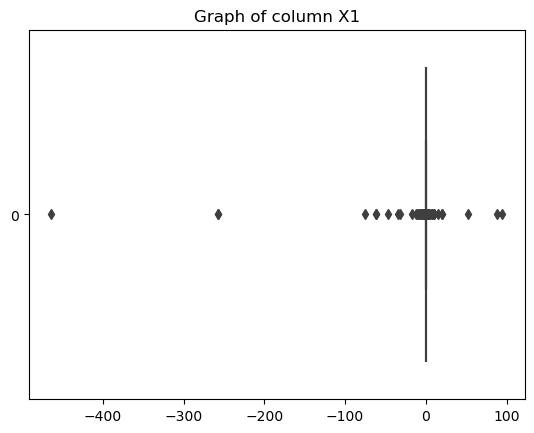

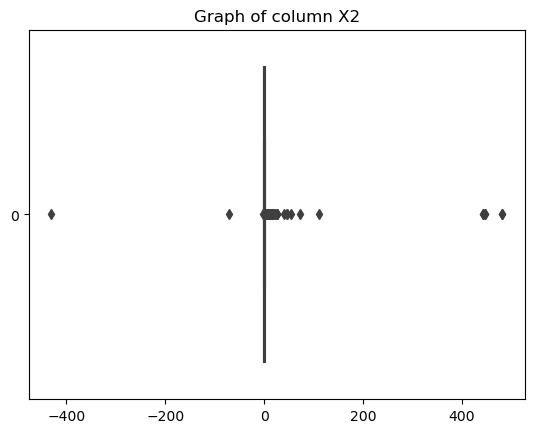

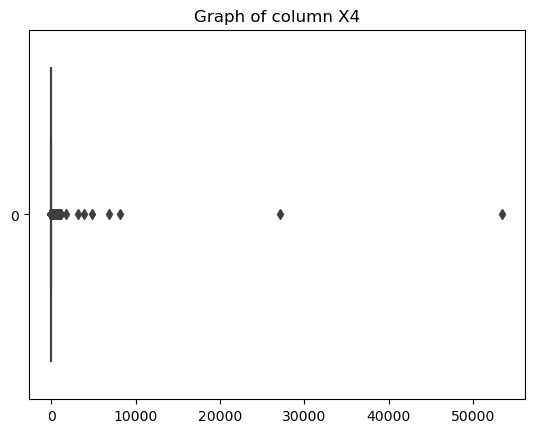

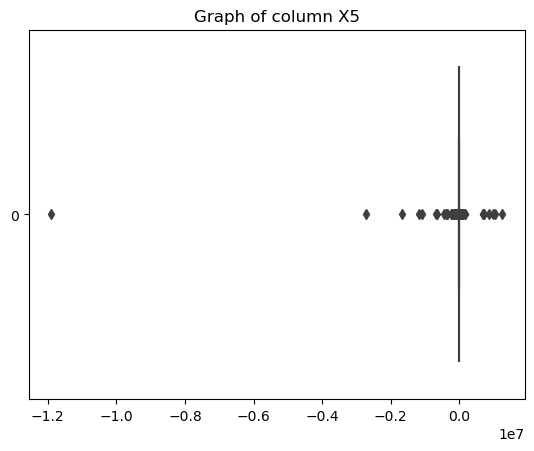

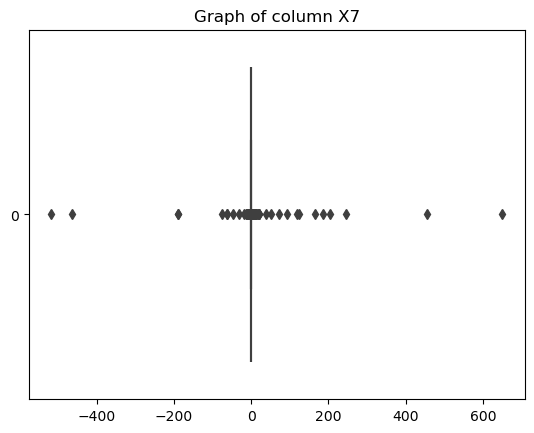

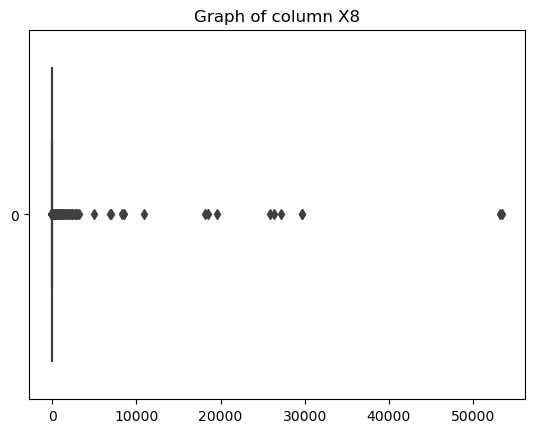

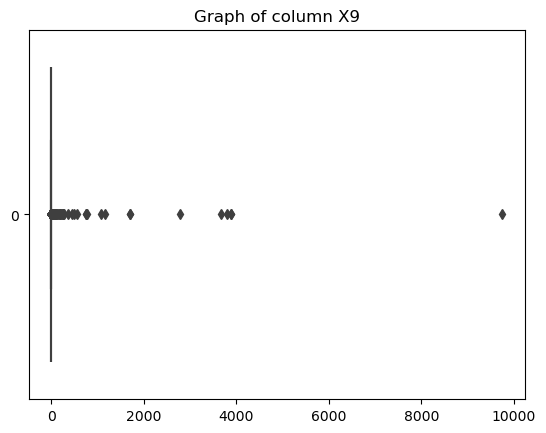

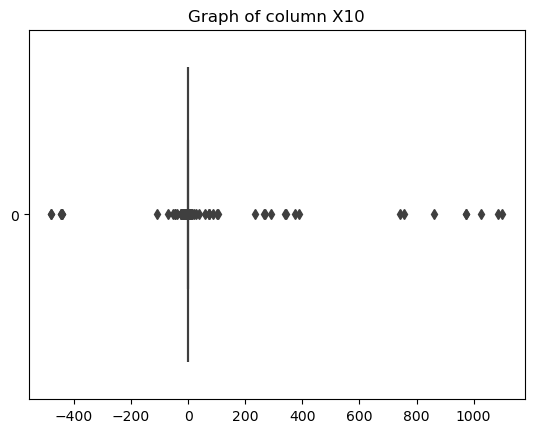

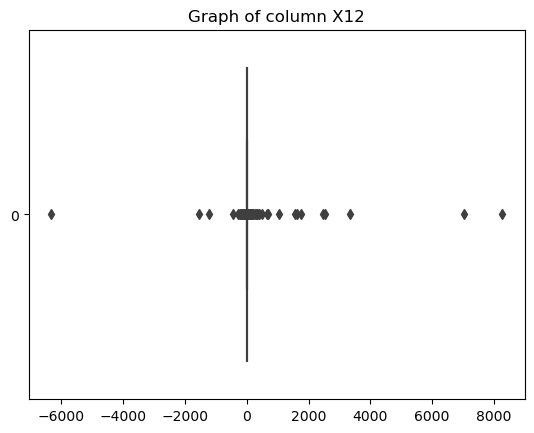

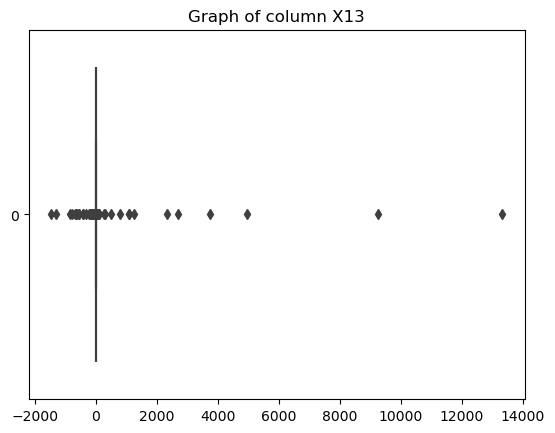

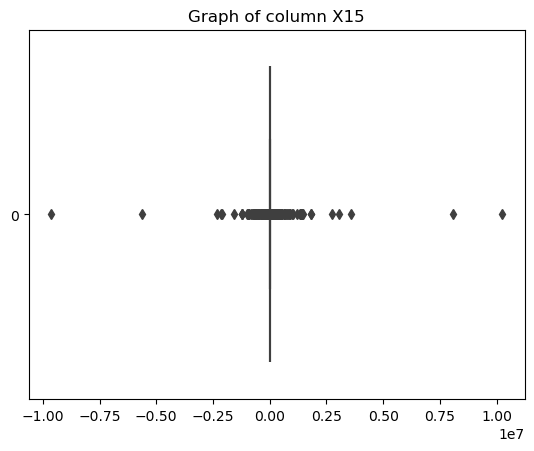

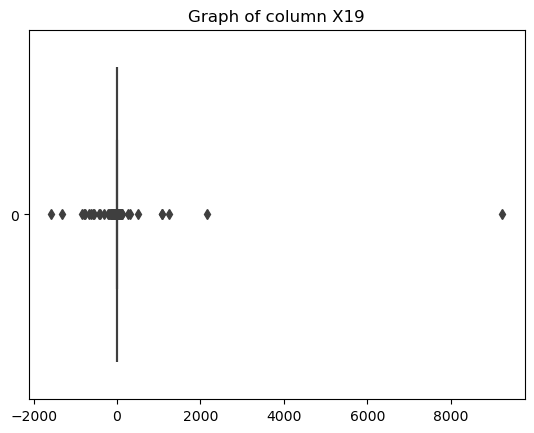

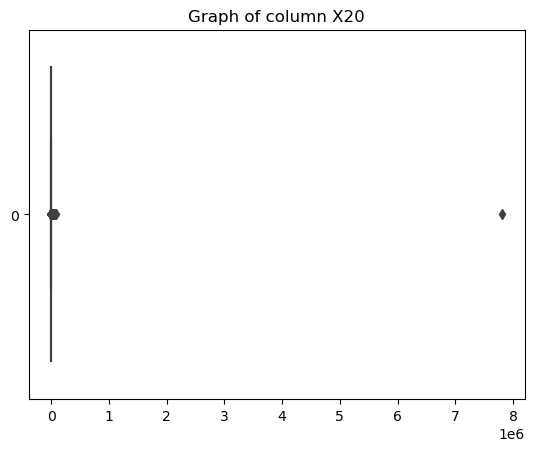

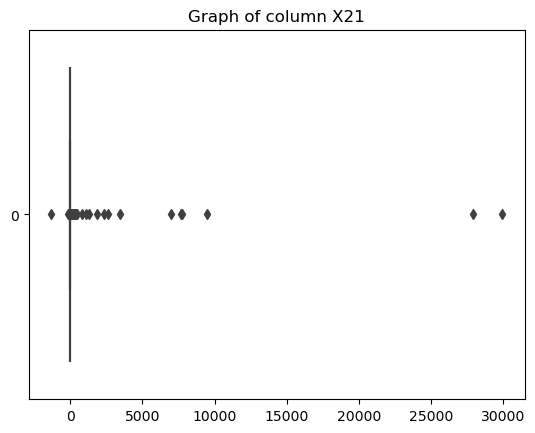

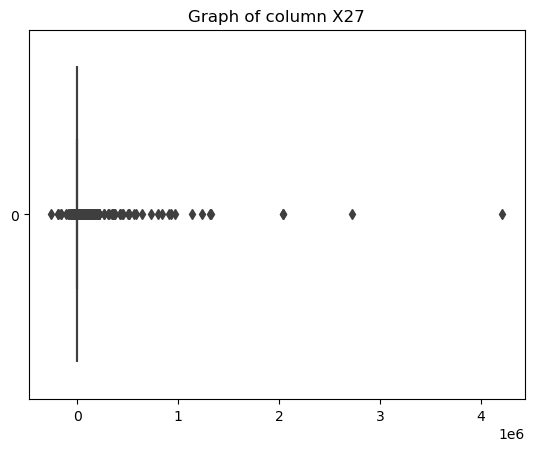

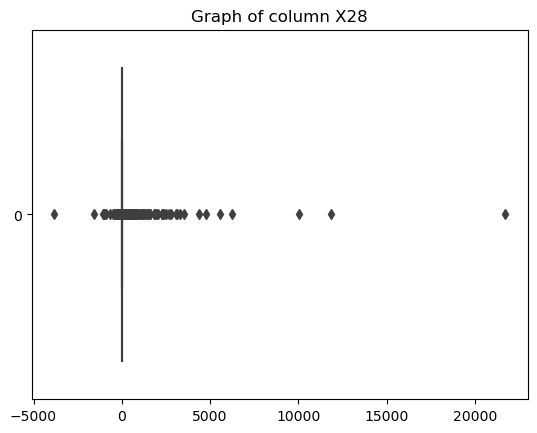

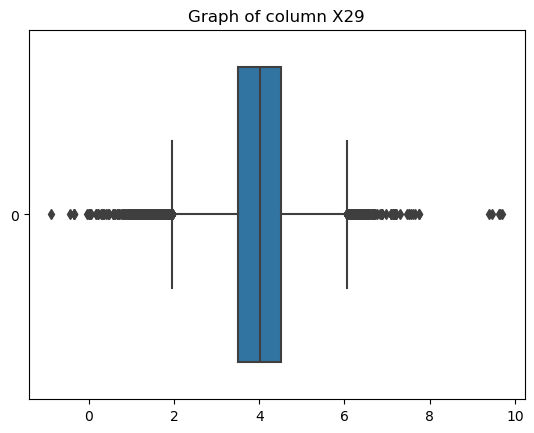

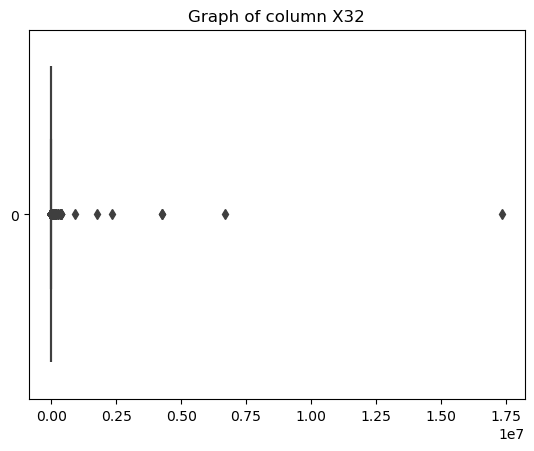

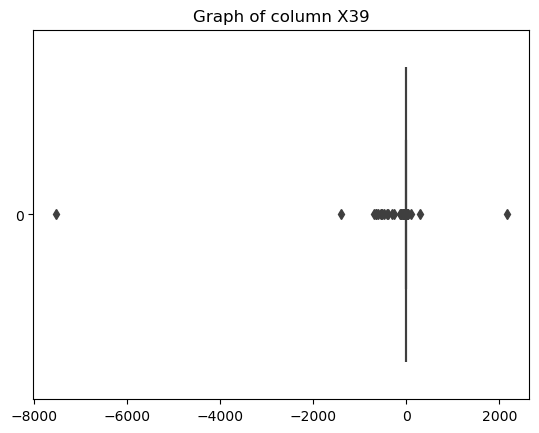

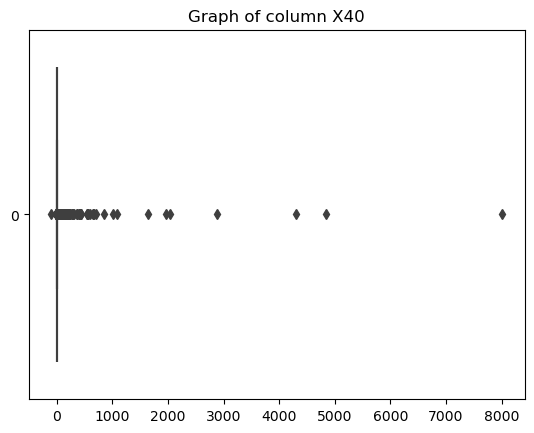

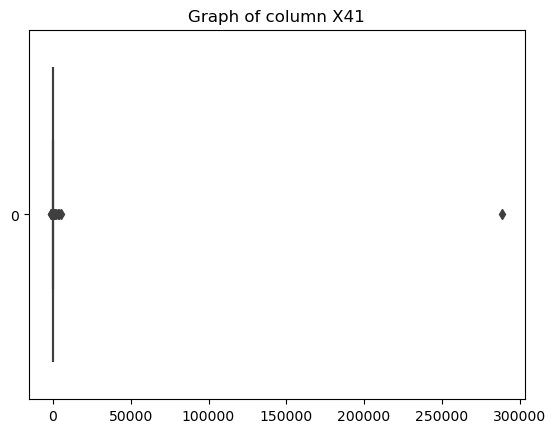

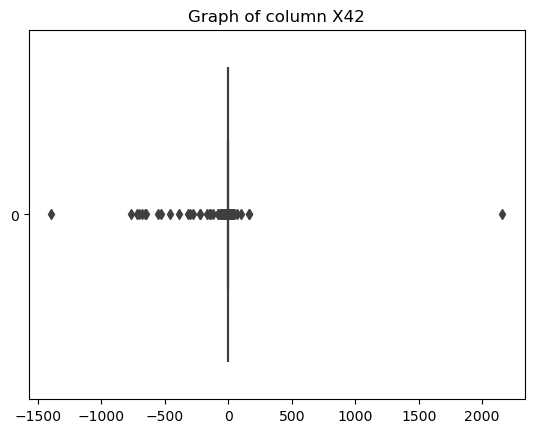

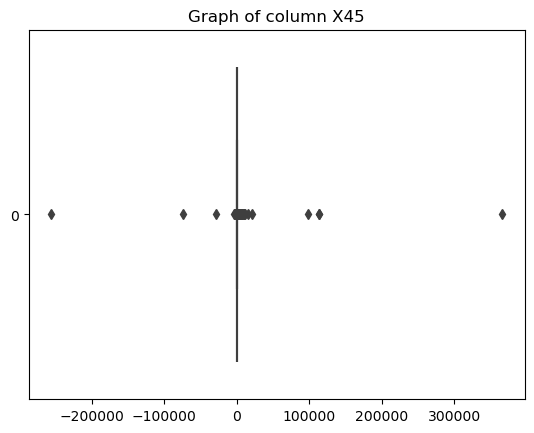

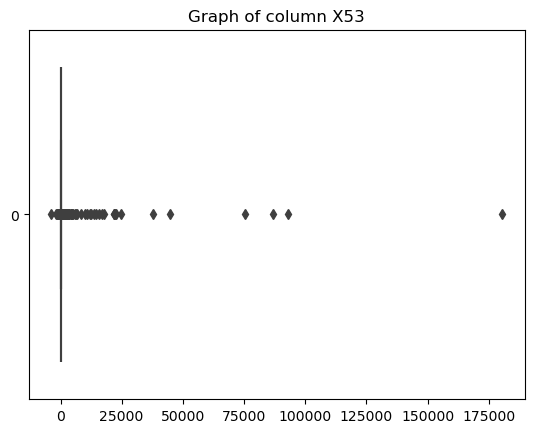

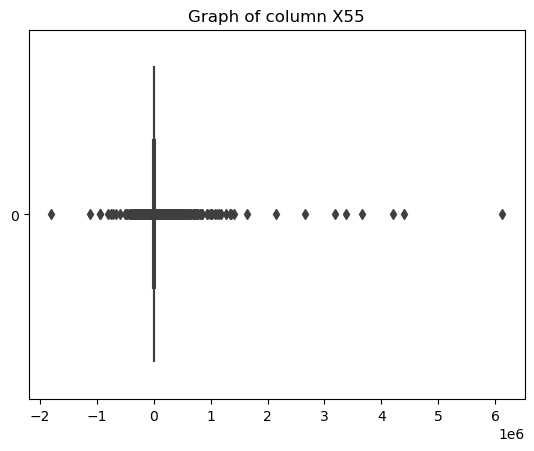

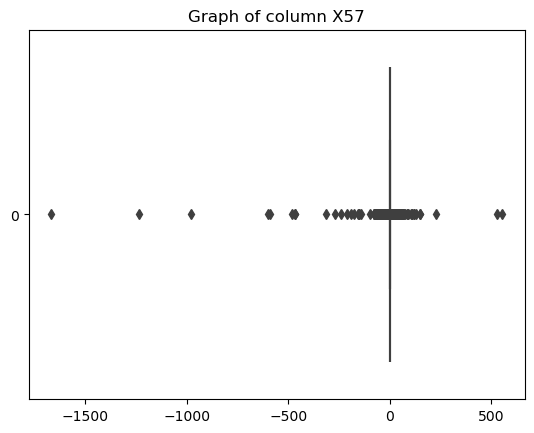

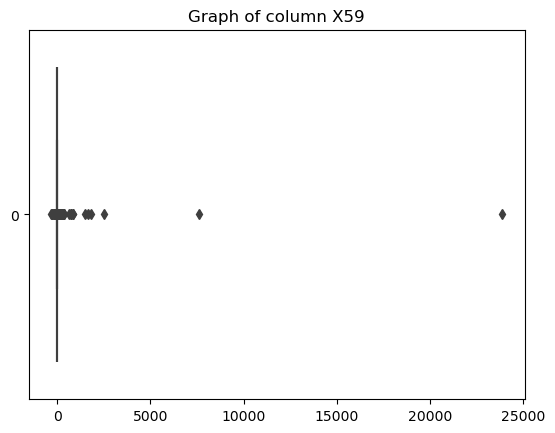

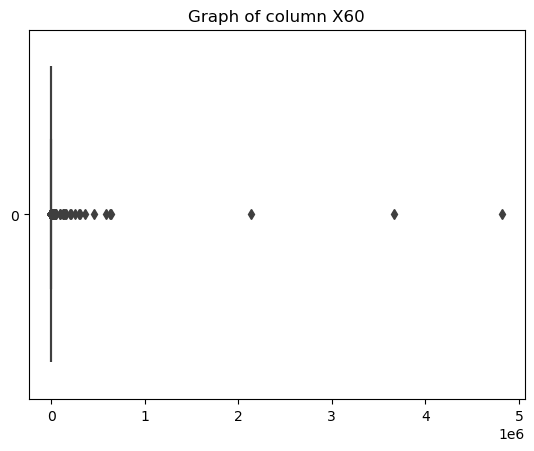

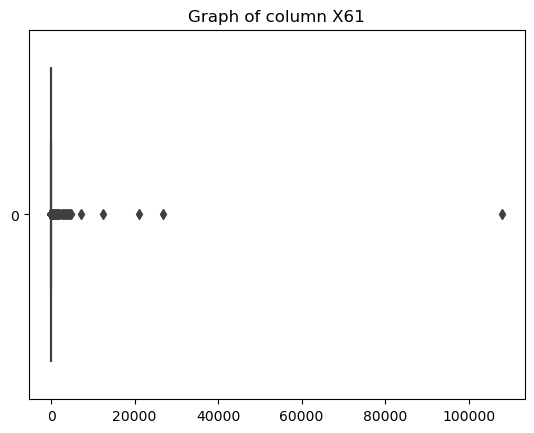

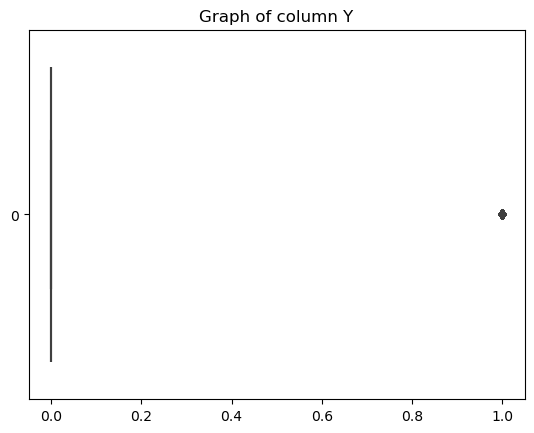

In [21]:
# Draw boxplot of df.
for col in df_num.columns:
    sns.boxplot(data=df[col], orient="h")
    plt.title('Graph of column {}'.format(col))
    plt.show();

In [22]:
# Function to replace ouliers using iqr.
def outlier_iqr(dataframe):
    for col in dataframe.columns:
        quartile1 = dataframe[col].quantile(0.25)
        quartile3 = dataframe[col].quantile(0.75)
        iqr = quartile3 - quartile1
        lower_limit = quartile1 - 1.5 * iqr
        upper_limit = quartile3 + 1.5 * iqr

        for data in dataframe[col]:
            
            if data < lower_limit:
                index = dataframe[dataframe[col]==data].index[0]
                df.loc[index, col] = lower_limit

            if data > upper_limit:
                index = dataframe[dataframe[col]==data].index[0]
                df.loc[index, col] = upper_limit

    return df

In [23]:
# Use the iqr outlier function.
df = outlier_iqr(df_num)

In [24]:
# View the new df.
df

,X1,X2,X4,X5,X7,X8,X9,X10,X12,X13,...,X41,X42,X45,X53,X55,X57,X59,X60,X61,Y
0,0.20,0.38,2.05,32.35,0.25,1.33,1.14,0.50,0.66,0.17,...,0.05,0.13,1.01,2.24,12441.98,0.40,0.00,8.42,5.14,0
1,0.21,0.50,1.94,14.79,0.26,1.00,1.70,0.50,0.52,0.16,...,0.06,0.15,0.51,4.52,2304.60,0.42,0.00,4.15,3.27,0
2,0.25,0.70,1.55,-1.15,0.31,0.44,1.31,0.30,0.64,0.24,...,0.07,0.23,0.95,1.21,6332.70,0.69,0.59,4.99,3.95,0
3,0.08,0.31,2.49,51.95,0.09,1.87,1.06,0.57,0.30,0.09,...,0.07,0.09,0.29,2.45,12441.98,0.14,0.00,4.57,3.61,0
4,0.19,0.61,1.41,-7.31,0.19,0.63,1.16,0.39,0.33,0.12,...,0.10,0.12,0.74,1.88,3186.60,0.48,0.12,6.40,4.32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43400,0.01,0.71,1.17,-18.91,0.01,0.42,1.68,0.29,0.06,0.02,...,0.36,0.02,0.10,0.40,3599.10,0.04,1.26,13.47,12.43,1
43401,-0.19,0.97,0.17,-67.36,-0.21,-0.40,0.94,-0.32,-0.60,-0.11,...,-0.07,-0.12,-14.84,-0.46,-7421.10,0.69,-0.02,42.13,19.22,1
43402,-0.18,1.26,0.75,-120.44,-0.15,-0.26,1.17,-0.32,-0.14,-0.07,...,0.21,0.09,-0.93,-1.62,-7421.10,0.55,-0.35,9.85,3.49,1
43403,-0.11,0.74,1.09,-17.00,-0.11,0.13,0.85,0.09,-0.62,-0.07,...,-0.24,-0.13,-1.39,0.12,1107.50,-0.39,0.59,13.89,6.08,1


In [25]:
# Get df statistics again.
df_stat = df_num.describe()
df_stat

,X1,X2,X4,X5,X7,X8,X9,X10,X12,X13,...,X41,X42,X45,X53,X55,X57,X59,X60,X61,Y
count,43397.00,43397.00,43271.00,43316.00,43397.00,43311.00,43396.00,43397.00,43271.00,43278.00,...,42651.00,43278.00,41258.00,42593.00,43404.00,43398.00,43398.00,41253.00,43303.00,43405.00
mean,0.04,0.59,6.31,-385.35,0.09,12.64,2.65,0.63,1.13,0.81,...,7.72,-0.14,14.83,23.77,7672.19,-0.01,1.33,448.09,17.03,0.05
std,2.99,5.84,295.43,61243.03,5.71,505.89,62.93,14.67,67.59,86.94,...,1398.84,15.99,2428.24,1213.80,70053.10,13.67,122.10,32345.60,553.05,0.21
min,-463.89,-430.87,-0.40,-11903000.00,-517.48,-141.41,-3.50,-479.91,-6331.80,-1460.60,...,-1234.40,-1395.80,-256230.00,-3828.90,-1805200.00,-1667.30,-327.97,-12.44,-12.66,0.00
25%,0.00,0.27,1.05,-49.08,0.01,0.43,1.02,0.30,0.02,0.02,...,0.03,0.00,0.02,0.69,27.55,0.01,0.00,5.55,4.51,0.00
50%,0.05,0.47,1.57,-1.03,0.06,1.07,1.20,0.51,0.17,0.07,...,0.09,0.04,0.28,1.21,1088.35,0.12,0.01,9.79,6.64,0.00
75%,0.13,0.69,2.79,50.63,0.15,2.62,2.06,0.71,0.59,0.13,...,0.21,0.09,0.96,2.22,4993.32,0.28,0.24,20.18,10.39,0.00
max,94.28,480.96,53433.00,1250100.00,649.23,53432.00,9742.30,1099.50,8259.40,13315.00,...,288770.00,2156.80,366030.00,180440.00,6123700.00,552.64,23853.00,4818700.00,108000.00,1.00


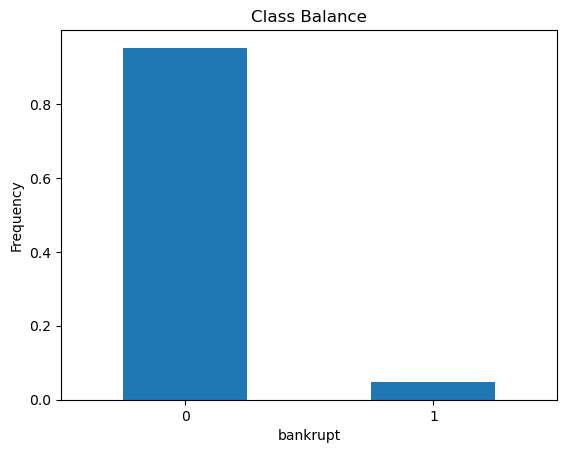

In [26]:
# Plot class balance.
df["Y"].value_counts(normalize=True).plot(kind="bar",
                                          xlabel="bankrupt",
                                          ylabel="Frequency",
                                          title="Class Balance")

plt.xticks(rotation='horizontal');

In [27]:
# Create data for computation.
target = "Y"
X = df.drop(columns=target)
y = df[target]

# Print data shapes.
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (43405, 29)
y shape: (43405,)


In [28]:
# Divide dataset into training and test sets using randomized split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_train.shape)
print("y_test shape:", y_train.shape)

X_train shape: (34724, 29)
y_train shape: (34724,)
X_test shape: (34724, 29)
y_test shape: (34724,)


In [29]:
# Create X_train_over and y_train_over by performing random over-sampling.
over_sampler = RandomOverSampler()
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (66148, 29)


,X1,X2,X4,X5,X7,X8,X9,X10,X12,X13,...,X40,X41,X42,X45,X53,X55,X57,X59,X60,X61
0,-0.06,0.44,1.57,23.30,-0.06,1.26,0.95,0.56,-0.14,-0.02,...,0.36,-0.24,-0.06,-0.49,1.44,8934.00,-0.10,0.10,11.85,3.94
1,-0.13,0.85,0.97,-39.44,-0.13,0.17,3.03,0.15,-0.15,0.08,...,0.03,0.08,0.00,-0.62,0.75,-1148.50,-0.39,0.00,14.73,5.30
2,-0.10,0.86,1.07,1.81,-0.10,0.16,2.28,0.14,-0.12,-0.04,...,0.01,0.47,0.00,-1.39,1.74,27.81,-0.39,0.00,42.13,2.65
3,0.18,0.76,1.09,-26.23,0.21,0.26,1.06,0.20,0.28,0.14,...,0.07,0.12,0.07,0.88,1.19,679.30,0.69,0.00,10.22,3.48
4,0.10,0.70,0.64,-92.90,0.10,0.42,1.06,0.29,0.27,0.12,...,0.05,0.19,0.05,0.59,0.38,-3695.50,0.33,0.59,7.85,19.22


In [30]:
# Create classifier clf to train X_train_over and y_train_over.
clf = make_pipeline(SimpleImputer(), StandardScaler(), XGBClassifier())
clf

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [31]:
# Check the steps.
clf.steps

[('simpleimputer', SimpleImputer()),
 ('standardscaler', StandardScaler()),
 ('xgbclassifier',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...))]

In [32]:
# Perform cross-validation with your classifier using the over-sampled training data.
cv_scores = cross_val_score(clf, X_train_over, y_train_over)
print(cv_scores)

[0.97928949 0.97271353 0.97475435 0.97633986 0.9751304 ]


In [33]:
# Define the parameters.
params = {"simpleimputer__strategy": ["mean", "median"],
          "xgbclassifier__n_estimators": range(20, 31, 5),
          "xgbclassifier__max_depth": range(2, 5)}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'xgbclassifier__n_estimators': range(20, 31, 5),
 'xgbclassifier__max_depth': range(2, 5)}

In [34]:
# Create a GridSearchCV that includes classifier and hyperparameter grid.
model = GridSearchCV(clf,
                     param_grid=params,
                     cv=5,
                     n_jobs=-1,
                     verbose=1)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'simpleimputer__strategy': ['mean', 'median'],
                         'xgbclassifier__max_depth': range(2, 5),
                         'xgbclassifier__n_estimators': range(20, 31, 5)},
             verbose=1)

In [35]:
# Fit X_train_over and y_train_over to the GridSearchCV.
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'simpleimputer__strategy': ['mean', 'median'],
                         'xgbclassifier__max_depth': range(2, 5),
                         'xgbclassifier__n_estimators': range(20, 31, 5)},
             verbose=1)

In [36]:
# Create a dataframe from the results.
cv_results = pd.DataFrame(model.cv_results_).sort_values("rank_test_score")
cv_results["param_max_depth"] = cv_results["param_xgbclassifier__max_depth"]
cv_results["param_n_estimators"] = cv_results["param_xgbclassifier__n_estimators"]
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_simpleimputer__strategy,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_max_depth,param_n_estimators
8,1.53,0.02,0.05,0.00,mean,4,30,"{'simpleimputer__strategy': 'mean', 'xgbclassi...",0.86,0.86,0.86,0.87,0.87,0.86,0.00,1,4,30
17,2.01,0.18,0.05,0.00,median,4,30,"{'simpleimputer__strategy': 'median', 'xgbclas...",0.86,0.86,0.87,0.87,0.87,0.86,0.00,2,4,30
7,1.43,0.02,0.05,0.01,mean,4,25,"{'simpleimputer__strategy': 'mean', 'xgbclassi...",0.85,0.85,0.86,0.86,0.86,0.86,0.00,3,4,25
16,2.01,0.11,0.05,0.01,median,4,25,"{'simpleimputer__strategy': 'median', 'xgbclas...",0.85,0.85,0.85,0.86,0.86,0.85,0.00,4,4,25
6,1.33,0.03,0.05,0.00,mean,4,20,"{'simpleimputer__strategy': 'mean', 'xgbclassi...",0.85,0.84,0.85,0.85,0.85,0.85,0.00,5,4,20


In [37]:
# Extract the best hyperparameters from model.
best_params = model.best_params_
print(best_params)

{'simpleimputer__strategy': 'mean', 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 30}


In [38]:
# Compute train and test scores.
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 0.8686
Model Test Accuracy: 0.8403


In [39]:
# Count the values in test.
y_test.value_counts()

Y
0    8241
1     440
Name: count, dtype: int64

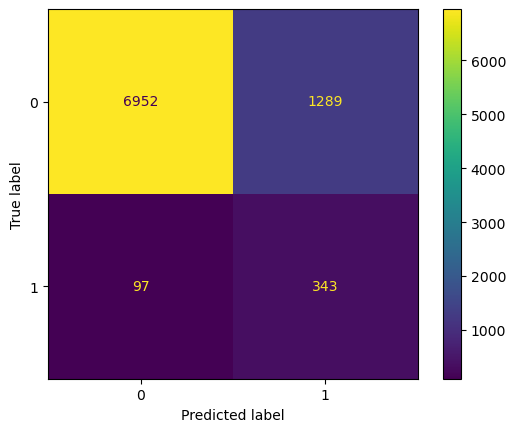

In [40]:
# Plot a confusion matrix that shows how your model performed on your test set
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [41]:
# Generate a classification report for model's performance.
class_report = classification_report(y_test, model.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      8241
           1       0.21      0.78      0.33       440

    accuracy                           0.84      8681
   macro avg       0.60      0.81      0.62      8681
weighted avg       0.95      0.84      0.88      8681



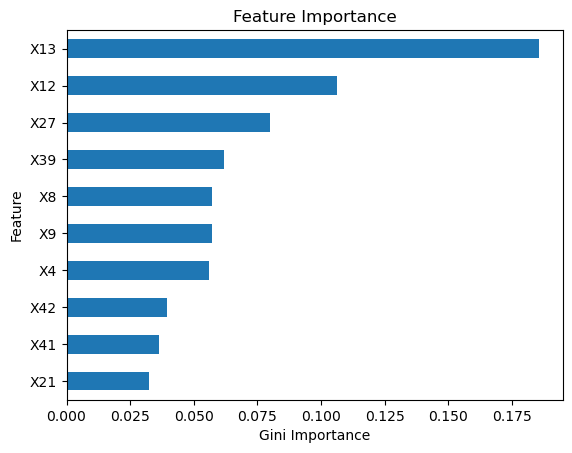

In [42]:
# Get feature names from training data.
features = X_train_over.columns

# Extract importances from model.
importances = model.best_estimator_.named_steps["xgbclassifier"].feature_importances_

# Create a series with feature names and importances.
feat_imp = pd.Series(importances, index=features).sort_values()

# Plot 10 most important features.
feat_imp.tail(10).plot(kind="barh", xlabel="Gini Importance", ylabel="Feature", title="Feature Importance");

In [43]:
# Save best-performing model to a file.
with open("data/Project_Notes_004_model_xgb.pkl", "wb") as f:
    pickle.dump(model, f)

In [44]:
# Get X_test sample data from df.
X_test_p = X_test.iloc[200:299]
X_test_p

,X1,X2,X4,X5,X7,X8,X9,X10,X12,X13,...,X40,X41,X42,X45,X53,X55,X57,X59,X60,X61
21528,0.09,0.42,1.87,-21.84,0.12,1.16,1.10,0.49,0.28,0.09,...,0.09,0.09,0.08,0.21,2.32,20105.00,0.19,0.00,3.69,5.13
32829,0.04,0.51,0.90,-31.50,0.06,0.97,1.48,0.49,0.12,0.09,...,0.09,0.09,0.07,0.70,0.90,-70.36,0.09,0.00,23.22,4.23
26115,0.11,0.25,2.93,-29.23,0.14,3.06,1.42,0.75,0.58,0.13,...,0.13,0.05,0.08,0.20,2.41,11359.00,0.15,0.02,2.59,13.27
9172,-0.05,1.00,0.76,-89.72,-0.06,-0.01,1.03,-0.01,-0.06,-0.00,...,0.13,0.22,0.03,-0.10,-0.03,-7421.10,0.69,-0.35,6.33,19.22
24799,0.04,0.79,0.73,-198.65,0.04,0.26,2.91,0.21,0.06,0.03,...,0.03,0.21,0.02,0.23,0.42,-7421.10,0.20,0.18,16.53,9.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4241,0.00,0.68,1.57,29.38,0.02,0.42,1.01,0.29,0.07,0.11,...,0.14,0.15,0.03,0.03,0.48,12441.98,0.01,0.59,18.31,3.64
354,0.04,0.48,0.73,-67.44,0.05,1.10,1.12,0.52,0.22,0.13,...,0.04,0.15,0.11,1.24,0.63,-7421.10,0.08,0.45,18.58,4.87
29322,0.32,0.11,5.39,200.21,0.37,5.89,1.56,0.89,1.44,0.30,...,1.55,0.01,0.23,NaN,4.52,6167.30,0.56,0.00,NaN,19.22
6793,0.03,0.66,0.98,-28.99,0.03,0.51,2.59,0.34,0.06,0.01,...,0.05,0.47,0.02,0.18,0.64,-28.00,0.10,0.00,13.42,10.25


In [45]:
# Get y_test sample data from df.
y_test_p = y_test.iloc[200:299]
y_test_p

21528    0
32829    0
26115    0
9172     0
24799    0
        ..
4241     0
354      0
29322    0
6793     1
26134    0
Name: Y, Length: 99, dtype: int64

In [46]:
# load the model from disk.
loaded_model = pickle.load(open("data/Project_Notes_004_model_xgb.pkl", 'rb'))
result = loaded_model.score(X_test_p, y_test_p).round(4)
print(result)

0.8889
